In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import tensorflow as tf

In [9]:
tf.__version__

'2.3.1'

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# загрузка датасета
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [12]:
train_x.shape

(60000, 28, 28)

In [13]:
# Меняем размерность тензора в размер нужный для нейросети и переводим данные из диапазона 
# от 0 до 255 в диапазон от 0 до 1 и тип float32
train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255

In [14]:
# Приводим тип данных Y в тип int32
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

In [15]:
print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(10000, 28, 28, 1) float32
(60000,) int32
(10000,) int32


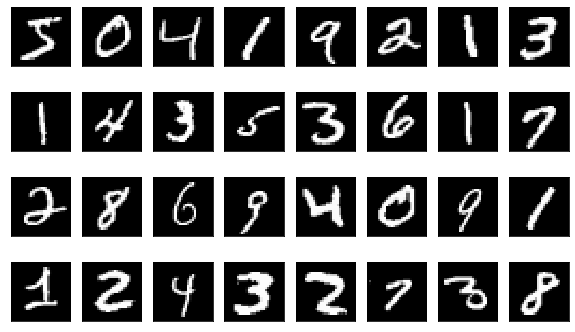

In [16]:
# Посмотрим на последние 32 цифры
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
class Model(tf.keras.Model):
    """
    Класс модели. Наследуется от Model
    """
    def __init__(self):
        super(Model, self).__init__()
        # Свертрчные слои с размерностью выходного пространства 32 и 64, с окном свертки 5х5, функция активации
        # relu и равномерным заполнением слоев
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        # Полносвязные слои с размерностью выходного пространства 256 и 10, с функцией активации relu и без нее
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        # Cлой объединения с размером окна 2х2 и шагом 2х2
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        # Слой, сглаживающий ввод
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        """
        Переопределяем функцию вызова. Собирает слои в модель
        """
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [19]:
# Создадим функцию потерь
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

In [20]:
# Создадим функцию точности
def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [21]:
# Зададим глобальные переменные

# Количество эпох обучения модели
NUM_EPOCHS = 4
# Размер пакета
BATCH_SIZE = 64
# Шаг обучения
LEARNING_RATE = 0.001

In [22]:
# Подготовим данные для обучения

# Создаем срезы тензоров из тренировочных данных
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# Случайным образом перемешиваем данные
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
# Повторяем данные по количеству эпох
train_ds = train_ds.repeat(NUM_EPOCHS)
# Создаем пакеты данных
train_ds = train_ds.batch(BATCH_SIZE)

In [23]:
# Создадим функцию оптимизации
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [24]:
# Создадим файл для записи результатов оптимизации
writer = tf.summary.create_file_writer('logs/adam')

In [25]:
# Создадим модель
model = Model()

In [27]:
# Обучим модель

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy: 20.70 %
[ 200] Accuracy: 99.22 %
[ 400] Accuracy: 99.22 %
[ 600] Accuracy: 99.61 %
[ 800] Accuracy: 100.00 %
[1000] Accuracy: 99.22 %
[1200] Accuracy: 97.66 %
[1400] Accuracy: 99.22 %
[1600] Accuracy: 100.00 %
[1800] Accuracy: 99.61 %
[2000] Accuracy: 100.00 %
[2200] Accuracy: 99.61 %
[2400] Accuracy: 99.22 %
[2600] Accuracy: 98.44 %
[2800] Accuracy: 99.61 %
[3000] Accuracy: 100.00 %
[3200] Accuracy: 99.61 %
[3400] Accuracy: 99.22 %
[3600] Accuracy: 99.61 %


In [29]:
# Оценка качества модели
test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print(f"Final Accuracy: {(accuracy_value * 100):.2f}%")

Final Accuracy: 99.02%


In [30]:
def test_item(sample):
    """
    Функция для предсказания
    """
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print(f'Predicted: {ans}')

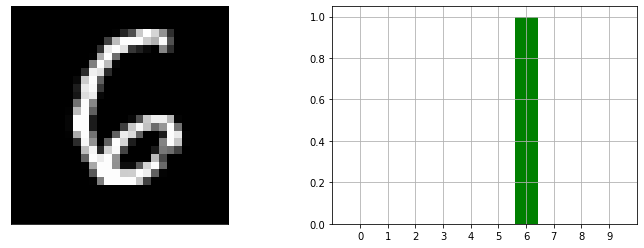

Predicted: 6
True Answer: 6


In [32]:
# Предсказание случайной цифры из MNIST
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print(f'True Answer: {test_y[idx]}')